In [25]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance


Read in data

In [26]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [27]:
# Format the data to work with existing code
labels = node_labels

# just look at a specified timepoint
dense_adj = As[1]

In [28]:
k=5
B=500
d=10
n=dense_adj.shape[0]

In [29]:
A_boots_list_prone = []
A_boots_list_knn = []
d_prone=6
for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_prone_bootstrap(dense_adj, d=d_prone, Q=1000, n_neighbors=k)
    A_boots_list_prone.append(A_boots)
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list_knn.append(A_boots)

100%|██████████| 500/500 [00:58<00:00,  8.48it/s]


In [30]:
A_prone_list = [dense_adj] + A_boots_list_prone
A_knn_list = [dense_adj] + A_boots_list_knn

yhat_prone = UASE(A_prone_list, d=d, sparse_matrix=False)
yhat_knn = UASE(A_knn_list, d=d, sparse_matrix=False)

<Axes: >

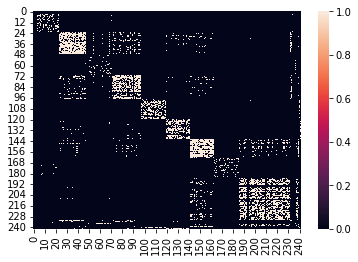

In [31]:
sns.heatmap(A_prone_list[1])

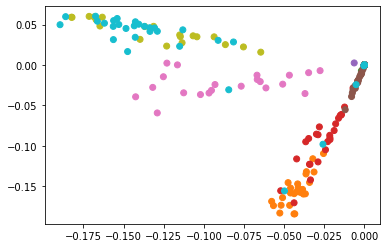

In [32]:
plt.scatter(yhat_prone[0:n, 0], yhat_prone[0:n, 1], c=labels, cmap="tab10")

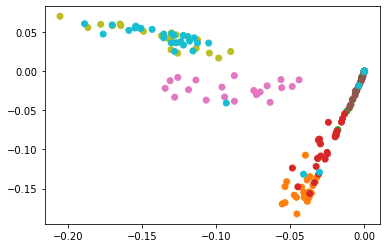

In [38]:
plt.scatter(yhat_prone[n:2*n, 0], yhat_prone[n:2*n, 1], c=labels, cmap="tab10")

In [33]:
yadflist=[]
for yhat in [yhat_prone,yhat_knn]:
    yadf = pd.DataFrame(yhat)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)
    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(labels))
    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)
    yadflist.append(yadf)

## Compute which nodes could be mistaken for which other nodes

In [34]:
k

5

In [35]:
def get_friends(yadf,threshold=3):
    """"create an adjacency matrix of nodes that overlap in uncertainty"""
    n=np.int64(yadf.shape[0]/(1+np.max(yadf["Matrix"])))
    in_cov_friends = np.zeros((n,n))
    
    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points, point, cov_d_dim, threshold=threshold)

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    return(in_cov_friends_symm)

in_cov_friends_symm_prone=get_friends(yadflist[0],threshold=3*6/10) # correction for dimensions differences
in_cov_friends_symm_knn=get_friends(yadflist[1],threshold=3)
#sns.heatmap(in_cov_friends_symm, square=True)
#print(np.mean(in_cov_friends_symm))

In [36]:
in_cov_friends_symm_prone=get_friends(yadflist[0],threshold=3*6/10) # correction for dimensions differences
in_cov_friends_symm_knn=get_friends(yadflist[1],threshold=3)

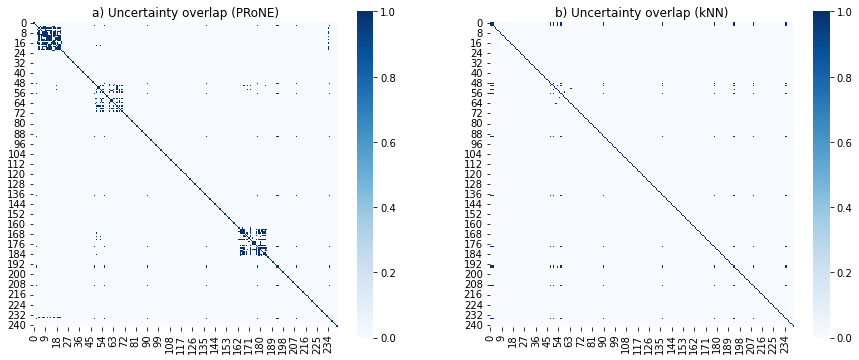

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(in_cov_friends_symm_prone, square=True,ax=ax1,cmap='Blues')
sns.heatmap(in_cov_friends_symm_knn, square=True,ax=ax2,cmap='Blues')
ax1.set_title("a) Uncertainty overlap (PRoNE)")
ax2.set_title("b) Uncertainty overlap (kNN)")
# plt.savefig("FigFriendsProneVsKnn.png", facecolor='w')
plt.show()
